In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 

from vehicle_model_DDPG2 import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_93_275.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00005
BATCH_SIZE = 32 
DELAY_TRAINING = 5000  

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    actor_model.save_weights("./{}/actor_model_checkpoint".format(root))
    critic_model.save_weights("./{}/critic_model_checkpoint".format(root))
    target_actor.save_weights("./{}/target_actor_checkpoint".format(root))
    target_critic.save_weights("./{}/target_critic_checkpoint".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.plot(test_cycle)
    plt.show() 
    return env.history  
    


Trial 0

maximum steps, simulation is done ... 
elapsed_time: 11.813
Episode: 1 Exploration P: 1.0000 Total reward: -1432.1025659007933 SOC: 0.8162 Cumulative_SOC_deviation: 113.3087 Fuel Consumption: 299.0152

maximum steps, simulation is done ... 
elapsed_time: 12.334
Episode: 2 Exploration P: 1.0000 Total reward: -1404.1436546306336 SOC: 0.8111 Cumulative_SOC_deviation: 111.1727 Fuel Consumption: 292.4163

maximum steps, simulation is done ... 
elapsed_time: 12.607
Episode: 3 Exploration P: 1.0000 Total reward: -1425.081961705838 SOC: 0.8162 Cumulative_SOC_deviation: 112.5045 Fuel Consumption: 300.0367

maximum steps, simulation is done ... 
elapsed_time: 12.218
Episode: 4 Exploration P: 1.0000 Total reward: -1405.148235735684 SOC: 0.8108 Cumulative_SOC_deviation: 111.3651 Fuel Consumption: 291.4969


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to Tensor

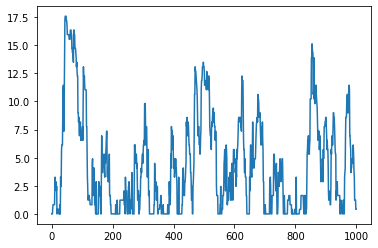

maximum steps, simulation is done ... 
elapsed_time: 66.386
Episode: 11 Exploration P: 0.7430 Total reward: -1139.5376223821206 SOC: 0.7711 Cumulative_SOC_deviation: 90.3672 Fuel Consumption: 235.8657

maximum steps, simulation is done ... 
elapsed_time: 67.107
Episode: 12 Exploration P: 0.7073 Total reward: -1106.4440322991547 SOC: 0.7646 Cumulative_SOC_deviation: 87.4174 Fuel Consumption: 232.2700

maximum steps, simulation is done ... 
elapsed_time: 67.162
Episode: 13 Exploration P: 0.6732 Total reward: -1010.277195213491 SOC: 0.7563 Cumulative_SOC_deviation: 79.0265 Fuel Consumption: 220.0119

maximum steps, simulation is done ... 
elapsed_time: 68.745
Episode: 14 Exploration P: 0.6408 Total reward: -955.7022251772761 SOC: 0.7456 Cumulative_SOC_deviation: 75.4670 Fuel Consumption: 201.0324



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:252: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:253: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:278: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization

SOC is nan...
elapsed_time: 64.967
Episode: 15 Exploration P: 0.6111 Total reward: -10872.233895924239 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 191.2779

maximum steps, simulation is done ... 
elapsed_time: 66.733
Episode: 16 Exploration P: 0.5818 Total reward: -849.1591206427958 SOC: 0.7271 Cumulative_SOC_deviation: 65.9322 Fuel Consumption: 189.8367

maximum steps, simulation is done ... 
elapsed_time: 62.349
Episode: 17 Exploration P: 0.5539 Total reward: -823.2419717019012 SOC: 0.7275 Cumulative_SOC_deviation: 63.8778 Fuel Consumption: 184.4635

Available condition is not avail... SOC: 0.7100036452976995
elapsed_time: 53.560
Episode: 18 Exploration P: 0.5293 Total reward: -696.7594145824875 SOC: 0.7100 Cumulative_SOC_deviation: 53.4446 Fuel Consumption: 162.3136

maximum steps, simulation is done ... 
elapsed_time: 56.518
Episode: 19 Exploration P: 0.5039 Total reward: -757.5530903373372 SOC: 0.7134 Cumulative_SOC_deviation: 58.4469 Fuel Consumption: 173.0840

maxim

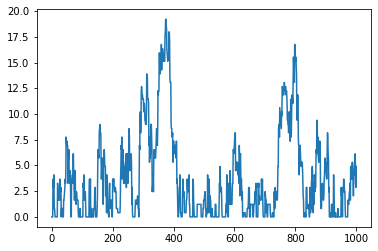

Available condition is not avail... SOC: 0.6846282563373921
elapsed_time: 53.517
Episode: 21 Exploration P: 0.4587 Total reward: -555.0415154156218 SOC: 0.6846 Cumulative_SOC_deviation: 40.2479 Fuel Consumption: 152.5628



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:252: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:253: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


Available condition is not avail... SOC: 0.6479086780348604
elapsed_time: 32.226
Episode: 22 Exploration P: 0.4463 Total reward: -227.0223708668789 SOC: 0.6479 Cumulative_SOC_deviation: 14.5094 Fuel Consumption: 81.9285

maximum steps, simulation is done ... 
elapsed_time: 62.371
Episode: 23 Exploration P: 0.4250 Total reward: -597.3786194311793 SOC: 0.6770 Cumulative_SOC_deviation: 45.4654 Fuel Consumption: 142.7248

maximum steps, simulation is done ... 
elapsed_time: 69.116
Episode: 24 Exploration P: 0.4047 Total reward: -619.1824923691204 SOC: 0.6965 Cumulative_SOC_deviation: 48.4425 Fuel Consumption: 134.7571

maximum steps, simulation is done ... 
elapsed_time: 70.405
Episode: 25 Exploration P: 0.3855 Total reward: -591.5997533970568 SOC: 0.6875 Cumulative_SOC_deviation: 45.5535 Fuel Consumption: 136.0646

maximum steps, simulation is done ... 
elapsed_time: 67.577
Episode: 26 Exploration P: 0.3671 Total reward: -572.7072351118967 SOC: 0.6868 Cumulative_SOC_deviation: 44.4120 Fue

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:278: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:279: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


SOC is nan...
elapsed_time: 9.217
Episode: 28 Exploration P: 0.3469 Total reward: -10032.319437833909 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 22.8892

maximum steps, simulation is done ... 
elapsed_time: 57.825
Episode: 29 Exploration P: 0.3305 Total reward: -491.47045332978894 SOC: 0.6752 Cumulative_SOC_deviation: 37.4263 Fuel Consumption: 117.2076

Available condition is not avail... SOC: 0.6468103598414244
elapsed_time: 48.788
Episode: 30 Exploration P: 0.3169 Total reward: -312.329619813415 SOC: 0.6468 Cumulative_SOC_deviation: 22.0779 Fuel Consumption: 91.5511

SOC is nan...
******************* Test is start *****************
Total reward: -10035.298557431925 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 12.2525
******************* Test is done *****************



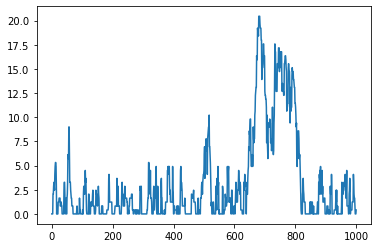

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:252: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:253: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver2\vehicle_model_DDPG2.py:278: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization

SOC is nan...
elapsed_time: 24.894
Episode: 31 Exploration P: 0.3104 Total reward: -10118.523871886287 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 50.6834

maximum steps, simulation is done ... 
elapsed_time: 57.685
Episode: 32 Exploration P: 0.2957 Total reward: -463.4583617490805 SOC: 0.6722 Cumulative_SOC_deviation: 35.6691 Fuel Consumption: 106.7678

maximum steps, simulation is done ... 
elapsed_time: 56.295
Episode: 33 Exploration P: 0.2817 Total reward: -402.19108132756276 SOC: 0.6592 Cumulative_SOC_deviation: 30.8458 Fuel Consumption: 93.7334

maximum steps, simulation is done ... 
elapsed_time: 59.932
Episode: 34 Exploration P: 0.2685 Total reward: -496.9446649875612 SOC: 0.6729 Cumulative_SOC_deviation: 39.1893 Fuel Consumption: 105.0517



KeyboardInterrupt: 

In [15]:
# print(env.version)

num_trials = 1
results_dict = {} 
# driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:1]
reference_cycle = driver.get_cycle() 
reference_episode_num = 10 

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
        if ep < reference_episode_num: 
            driving_cycle = reference_cycle
        else: 
            driving_cycle = driver.get_cycle()
                
        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
    root = "DDPG3_trained"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [ ]:
with open("DDPG3.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# results_dict